# Analysis of experiments:

We use the JSON file $\textcolor{green}{\text{experiment.json}}$ to acces the results of each experiment. The keys of the JSON correspond to the name of each experiment, with the possible keys being: 

- $\textcolor{orange}{\text{delay\_measureAll\_noCorrection}}$: For the experiment that encodes the state $\ket{0}_L$, leaves a time delay and measure the seven qubits.
- $\textcolor{orange}{\text{delay\_+\_measureAll\_noCorrection}}$: Experiment that encodes the state $\ket{+}_L$, leaves a delay and measure the seven qubits.
- $\textcolor{orange}{\text{delay\_1\_measureAll\_noCorrection}}$: Experiment that encodes the state $\ket{1}_L$, leaves a delay and measure the seven qubits.
- $\textcolor{orange}{\text{delay\_-\_measureAll\_noCorrection}}$: Experiment that encodes the state $\ket{-}_L$, leaves a delay and measure the seven qubits.

<br>

- $\textcolor{orange}{\text{delay\_measureAll\_Correction}}$: For the experiment that encodes the state $\ket{0}_L$, leaves a time delay, performs error correction and measure the seven qubits.
- $\textcolor{orange}{\text{delay\_+\_measureAll\_Correction}}$: Experiment that encodes the state $\ket{+}_L$, leaves a delay, performs error correction and measure the seven qubits.
- $\textcolor{orange}{\text{delay\_1\_measureAll\_Correction}}$: Experiment that encodes the state $\ket{1}_L$, leaves a delay, performs error correction and measure the seven qubits.
- $\textcolor{orange}{\text{delay\_-\_measureAll\_Correction}}$: Experiment that encodes the state $\ket{-}_L$, leaves a delay, performs error correction and measure the seven qubits.


Some of this keys might not exists in the JSON, as the experiment might yet not been performed. Each key, corresponding to each experiment, contains a list of JSON, each JSON correspond to job in a IBM quantum computer. The keys of the JSON are:

- $\textcolor{orange}{\text{job\_id}}$: ID of the job.
- $\textcolor{orange}{\text{metadata}}$: Data about the experiment. Is a JSON with the following information:
    - $\textcolor{green}{\text{expected\_distribution}}$: Expected probability for each possible bitstring.
    - $\textcolor{green}{\text{t\_array}}$: Array of delays used for the experiment.
    - $\textcolor{green}{\text{initial\_layout}}$: Initial layout obtained in the transpilation process.
    - $\textcolor{green}{\text{estimated\_duration}}$: Estimated durations (usually un us) of each circuit.
    - $\textcolor{green}{\text{encoder\_type}}$: Indicate the encoder that was used. (universal, 0, 1).
    - $\textcolor{green}{\text{t\_array\_unit}}$: Indicate the unit used in $\textcolor{green}{\text{t\_array}}$.
    - $\textcolor{green}{\text{estimated\_duration\_unit}}$: Indicate the unit used in $\textcolor{green}{\text{estimated\_duration}}$.

In [20]:
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_ibm_runtime import SamplerV2

import sys
import os

sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../../.."))
import json
from utils import TVD, get_result
import matplotlib.pyplot as plt

In [12]:
ibm_token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token)

### First experiment: $\text{delay\_measureAll.ipynb}$ - Experiment 1

This experiment consist of encoding a $\ket{0}_L$ state in the Steane Code, add a time delay and measure the seven qubits of the code in the computational basis. The experiment name is $\textcolor{orange}{\text{delay\_measureAll\_noCorrection}}$. With this key we can extract the result of these experiment in $\textcolor{green}{\text{experiment.json}}$.

In [15]:
# Opening JSON file
json_file = os.path.abspath("experiments.json")
experiment_name = "delay_measureAll_noCorrection"
first_result = 0

result, job = get_result(json_file, experiment_name, service, first_result=first_result)

result, job

 > Job ID: cz7016410wx0008bz71g
 > Job Status: DONE



({'job_id': 'cz7016410wx0008bz71g',
  'metadata': {'expected_distribution': {'0000000': 0.125,
    '0001111': 0.125,
    '0110011': 0.125,
    '0111100': 0.125,
    '1010101': 0.125,
    '1011010': 0.125,
    '1100110': 0.125,
    '1101001': 0.125},
   't_array': [0,
    90000,
    180000,
    270000,
    360000,
    450000,
    540000,
    630000,
    720000,
    810000],
   'initial_layout': [122, 121, 123, 111, 120, 124, 119],
   'estimated_duration': [9.536,
    29.536,
    47.40266666666667,
    69.536,
    87.40266666666666,
    109.536,
    127.40266666666666,
    149.536,
    169.536,
    187.40266666666665],
   'encoder_type': '0',
   't_arrya_units': 'dt',
   'estimated_duration_units': 'us'}},
 <RuntimeJobV2('cz7016410wx0008bz71g', 'sampler')>)

In [16]:
# Get data of result['metadata'] and backend name
real_distribution = result['metadata']['expected_distribution']
t_array = result['metadata']['t_array']
initial_layout = result['metadata']['initial_layout']
backend_name = job._backend.name # job._backend gives a IBMBackend object
estimated_duration = result['metadata']['estimated_duration']
pub_result = job.result()

In [17]:
# Get dt of the backend:
backend = service.backend(backend_name)
sampler = SamplerV2(backend)
# Get the dt of the selected backend in nano seconds
print(f" > dt in seconds: {backend.configuration().dt} s")
dt = backend.configuration().dt * 10**9
print(f" > dt in ns: {round(dt, 3)} ns")

 > dt in seconds: 2.2222222222222221e-10 s
 > dt in ns: 0.222 ns


In [18]:
# get t_array in us:
t_array_us = [t*dt * 10**(-3) for t in t_array]
t_array_us

[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0]

In [19]:
# Compute TVD:
tvd = []
empirical_distribution_list = []

for i in range(len(pub_result)):
    counts = pub_result[i].data.physical_bits.get_counts()
    empirical_distribution = {}

    # Recall that qiskit gives the result in reverse order:
    shots = pub_result[i].data.physical_bits.num_shots
    for j in counts.keys():
        empirical_distribution[j[::-1]] = counts[j]/shots
        
    empirical_distribution_list.append(empirical_distribution)

    print(f" > Measured TVD in {backend_name}: {round(TVD(empirical_distribution, real_distribution), 2)} (delay of {t_array_us[i]} us = {t_array[i]} dt)")

    tvd.append(TVD(empirical_distribution, real_distribution))

 > Measured TVD in ibm_sherbrooke: 0.53 (delay of 0.0 us = 0 dt)
 > Measured TVD in ibm_sherbrooke: 0.65 (delay of 20.0 us = 90000 dt)
 > Measured TVD in ibm_sherbrooke: 0.64 (delay of 40.0 us = 180000 dt)
 > Measured TVD in ibm_sherbrooke: 0.78 (delay of 60.0 us = 270000 dt)
 > Measured TVD in ibm_sherbrooke: 0.76 (delay of 80.0 us = 360000 dt)
 > Measured TVD in ibm_sherbrooke: 0.82 (delay of 100.0 us = 450000 dt)
 > Measured TVD in ibm_sherbrooke: 0.8 (delay of 120.0 us = 540000 dt)
 > Measured TVD in ibm_sherbrooke: 0.83 (delay of 140.0 us = 630000 dt)
 > Measured TVD in ibm_sherbrooke: 0.84 (delay of 160.0 us = 720000 dt)
 > Measured TVD in ibm_sherbrooke: 0.84 (delay of 180.0 us = 810000 dt)


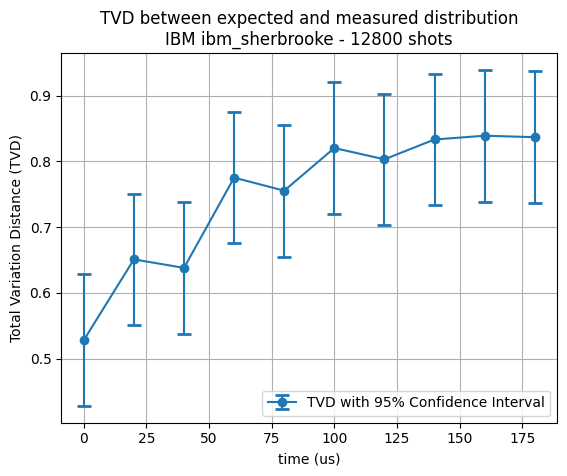

In [8]:
# plt.plot(t_array_us, tvd, 'o-g', label = 'TVD') # 'o-g' ~ 'marker|line|color' = 'o|-|green'
confidence = 0.1
lower_error = [confidence if d - confidence >= 0 else d for d in tvd]
upper_error = [confidence if d + confidence <= 1 else 1 - d for d in tvd]
error = [lower_error, upper_error]
plt.errorbar(t_array_us, tvd, yerr=error, fmt='o', capsize=5, capthick=2, linestyle='-', label="TVD with 95% Confidence Interval")

plt.legend()
plt.grid()
# plt.ylim(0, 1)
plt.xlabel("time (us)")
plt.ylabel("Total Variation Distance (TVD)")

# Here we suppose that the number of shots is equal for each circuit. 
plt.title(f"TVD between expected and measured distribution\nIBM {backend_name} - {shots} shots")

plt.show()

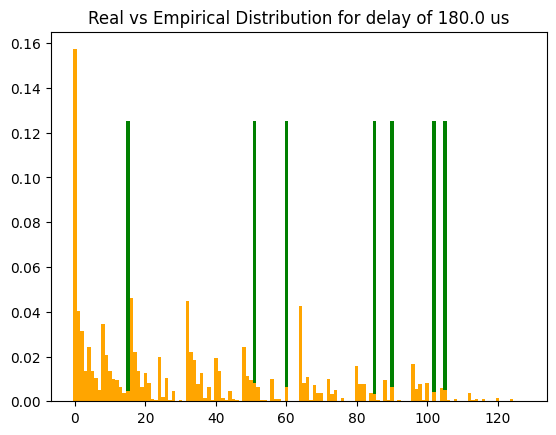

In [23]:
ordered_empirical_distribution = {}
ordered_real_distribution = {}

time_position = len(t_array) - 1

diference = {}
for i in range(2**7):
    key = bin(i)[2::]
    key = '0'*(7 - len(key)) + key

    if key in empirical_distribution_list[time_position].keys():
        ordered_empirical_distribution[i] = empirical_distribution_list[time_position][key]

    else:
        ordered_empirical_distribution[i] = 0

    if key in real_distribution.keys():
        ordered_real_distribution[i] = real_distribution[key]

    else:
        ordered_real_distribution[i] = 0

    diference[i] = abs(ordered_real_distribution[i] - ordered_empirical_distribution[i])
    
    # print('0'*(7 - len(key)) + key)

plt.bar(ordered_real_distribution.keys(), ordered_real_distribution.values(), width=1, color='g')
plt.bar(ordered_empirical_distribution.keys(), ordered_empirical_distribution.values(), width=1, color='orange')
plt.title(f"Real vs Empirical Distribution for delay of {t_array_us[time_position]} us")
plt.show()

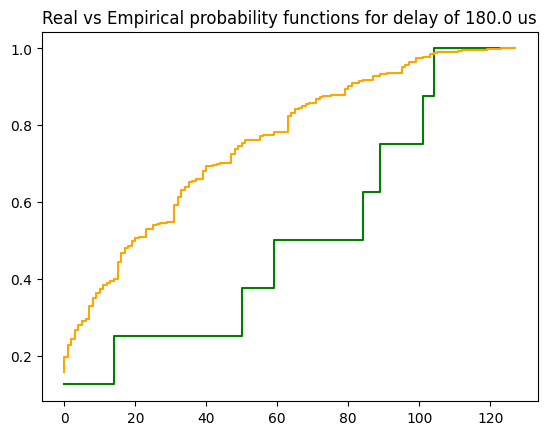

In [24]:
real_cumulative_distribution = []
empirical_cumulative_distribution = []

total_real_distribution = 0
total_empirical_distribution = 0
for key in ordered_real_distribution.keys():

    total_real_distribution += ordered_real_distribution[key]
    total_empirical_distribution += ordered_empirical_distribution[key]
    real_cumulative_distribution.append(total_real_distribution)
    empirical_cumulative_distribution.append(total_empirical_distribution)

plt.step([i for i in range(len(real_cumulative_distribution))], real_cumulative_distribution, color='g')
plt.step([i for i in range(len(real_cumulative_distribution))], empirical_cumulative_distribution, color='orange')
plt.title(f"Real vs Empirical probability functions for delay of {t_array_us[time_position]} us")
plt.show()

 > Job ID: cz3gpja10wx0008bad10
 > Job Status: DONE

 > Job ID: cytjpsb38jq0008xvh0g
 > Job Status: DONE

 > Job ID: cytehjejj6dg008g10e0
 > Job Status: DONE

 > Job ID: cyte000y2gd000882t50
 > Job Status: DONE

 > Job ID: cytdv4w38jq0008xthj0
 > Job Status: DONE



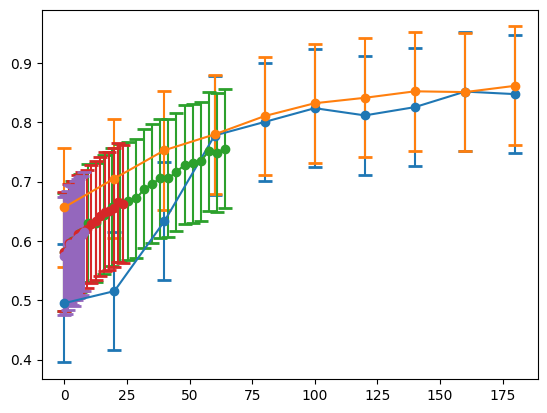

In [98]:
# Opening JSON file
json_file = os.path.abspath("experiments.json")
experiment_name = "delay_measureAll_noCorrection"

results, jobs = get_result(json_file, experiment_name, service, num_results=5)

for i in range(len(results)):
    result = results[i]
    job = jobs[i]
    # Get data of result['metadata'] and backend name
    real_distribution = result['metadata']['expected_distribution']
    t_array = result['metadata']['t_array']
    initial_layout = result['metadata']['initial_layout']
    backend_name = job._backend.name # job._backend gives a IBMBackend object
    estimated_duration = result['metadata']['estimated_duration']
    pub_result = job.result()

    # Get dt of the backend:
    backend = service.backend(backend_name)
    sampler = SamplerV2(backend)
    # Get the dt of the selected backend in nano seconds
    dt = backend.configuration().dt * 10**9



    t_array_us = [t*dt * 10**(-3) for t in t_array]


    # Compute TVD:
    tvd = []
    first_empirical_distribution = {}

    for i in range(len(pub_result)):
        counts = pub_result[i].data.physical_bits.get_counts()
        empirical_distribution = {}

        # Recall that qiskit gives the result in reverse order:
        shots = pub_result[i].data.physical_bits.num_shots
        for j in counts.keys():
            empirical_distribution[j[::-1]] = counts[j]/shots

            if i == 0:
                first_empirical_distribution[j[::-1]] = counts[j]/shots

        # print(f" > Measured TVD in {backend_name}: {round(TVD(empirical_distribution, real_distribution), 2)} (delay of {t_array_us[i]} us = {t_array[i]} dt)")

        tvd.append(TVD(empirical_distribution, real_distribution))

    
    confidence = 0.1
    lower_error = [confidence if d - confidence >= 0 else d for d in tvd]
    upper_error = [confidence if d + confidence <= 1 else 1 - d for d in tvd]
    error = [lower_error, upper_error]
    plt.errorbar(t_array_us, tvd, yerr=error, fmt='o', capsize=5, capthick=2, linestyle='-', label="TVD with 95% Confidence Interval")

### Second Experiment: $\text{delay\_+\_measureAll.ipynb}$ - Experiment 1

This experiment consist of encoding a $\ket{+}_L$ state in the Steane Code, add a time delay and measure the state adding. The experiment name is $\textcolor{orange}{\text{delay\_+\_measureAll\_noCorrection}}$. With this key we can extract the result of these experiment in $\textcolor{green}{\text{experiment.json}}$.

In [55]:
# Opening JSON file
experiment_name = "delay_+_measureAll_noCorrection"

result, job = get_result(json_file, experiment_name, service)

result, job

 > Job ID: cz1wtzb39f40008rz6hg
 > Job Status: DONE



({'job_id': 'cz1wtzb39f40008rz6hg',
  'metadata': {'expected_distribution': {'0000000': 0.0625,
    '0001111': 0.0625,
    '0110011': 0.0625,
    '0111100': 0.0625,
    '1010101': 0.0625,
    '1011010': 0.0625,
    '1100110': 0.0625,
    '1101001': 0.0625,
    '1111111': 0.0625,
    '1110000': 0.0625,
    '1001100': 0.0625,
    '1000011': 0.0625,
    '0101010': 0.0625,
    '0100101': 0.0625,
    '0011001': 0.0625,
    '0010110': 0.0625},
   't_array': [0,
    90000,
    180000,
    270000,
    360000,
    450000,
    540000,
    630000,
    720000,
    810000],
   'initial_layout': [60, 53, 59, 61, 58, 41, 71],
   'estimated_duration': [9.479111111111111,
    29.592888888888886,
    49.64977777777777,
    69.47911111111111,
    89.47911111111111,
    109.47911111111111,
    129.536,
    149.4791111111111,
    169.4791111111111,
    189.4791111111111],
   'encoder_type': 'universal',
   't_array_unit': 'dt',
   'estimated_duration_unit': 'us'}},
 <RuntimeJobV2('cz1wtzb39f40008rz6hg', 's

In [56]:
# Get data of result['metadata'] and backend name
real_distribution = result['metadata']['expected_distribution']
t_array = result['metadata']['t_array']
initial_layout = result['metadata']['initial_layout']
backend_name = job._backend.name # job._backend gives a IBMBackend object
pub_result = job.result()

In [57]:
# Get dt of the backend:
backend = service.backend(backend_name)
sampler = SamplerV2(backend)
# Get the dt of the selected backend in nano seconds
print(f" > dt in seconds: {backend.configuration().dt} s")
dt = backend.configuration().dt * 10**9
print(f" > dt in ns: {round(dt, 3)} ns")

 > dt in seconds: 2.2222222222222221e-10 s
 > dt in ns: 0.222 ns


In [58]:
# get t_array in us:
t_array_us = [t*dt * 10**(-3) for t in t_array]
t_array_us

[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0]

In [59]:
# Compute TVD:
tvd = []
empirical_distribution_list = []

for i in range(len(pub_result)):
    counts = pub_result[i].data.physical_bits.get_counts()
    empirical_distribution = {}

    # Recall that qiskit gives the result in reverse order:
    shots = pub_result[i].data.physical_bits.num_shots
    for j in counts.keys():
        empirical_distribution[j[::-1]] = counts[j]/shots
        
    empirical_distribution_list.append(empirical_distribution)

    print(f" > Measured TVD in {backend_name}: {round(TVD(empirical_distribution, real_distribution), 2)} (delay of {t_array_us[i]} us = {t_array[i]} dt)")

    tvd.append(TVD(empirical_distribution, real_distribution))

 > Measured TVD in ibm_sherbrooke: 0.59 (delay of 0.0 us = 0 dt)
 > Measured TVD in ibm_sherbrooke: 0.69 (delay of 20.0 us = 90000 dt)
 > Measured TVD in ibm_sherbrooke: 0.73 (delay of 40.0 us = 180000 dt)
 > Measured TVD in ibm_sherbrooke: 0.76 (delay of 60.0 us = 270000 dt)
 > Measured TVD in ibm_sherbrooke: 0.78 (delay of 80.0 us = 360000 dt)
 > Measured TVD in ibm_sherbrooke: 0.81 (delay of 100.0 us = 450000 dt)
 > Measured TVD in ibm_sherbrooke: 0.82 (delay of 120.0 us = 540000 dt)
 > Measured TVD in ibm_sherbrooke: 0.82 (delay of 140.0 us = 630000 dt)
 > Measured TVD in ibm_sherbrooke: 0.84 (delay of 160.0 us = 720000 dt)
 > Measured TVD in ibm_sherbrooke: 0.86 (delay of 180.0 us = 810000 dt)


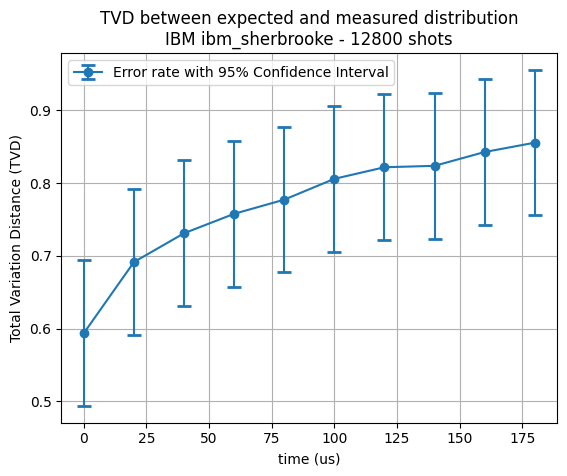

In [60]:
# plt.plot(t_array_us, tvd, 'o-g', label = 'TVD') # 'o-g' ~ 'marker|line|color' = 'o|-|green'
confidence = 0.1
lower_error = [confidence if d - confidence >= 0 else d for d in tvd]
upper_error = [confidence if d + confidence <= 1 else 1 - d for d in tvd]
error = [lower_error, upper_error]
plt.errorbar(t_array_us, tvd, yerr=error, fmt='o', capsize=5, capthick=2, linestyle='-', label="Error rate with 95% Confidence Interval")

plt.legend()
plt.grid()
plt.xlabel("time (us)")
plt.ylabel("Total Variation Distance (TVD)")

# Here we suppose that the number of shots is equal for each circuit. 
plt.title(f"TVD between expected and measured distribution\nIBM {backend_name} - {shots} shots")

plt.show()

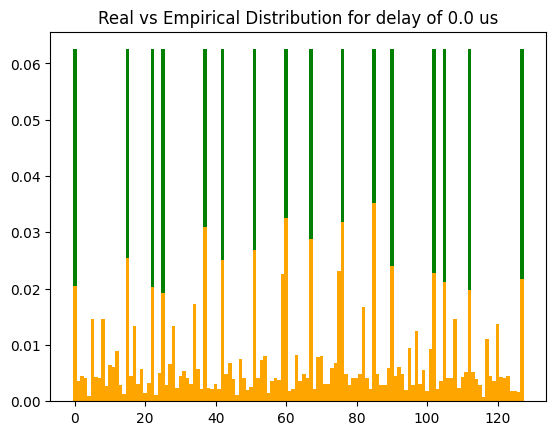

In [ ]:
ordered_empirical_distribution = {}
ordered_real_distribution = {}

time_position = 0

diference = {}
for i in range(2**7):
    key = bin(i)[2::]
    key = '0'*(7 - len(key)) + key

    if key in empirical_distribution_list[time_position].keys():
        ordered_empirical_distribution[i] = empirical_distribution_list[time_position][key]

    else:
        ordered_empirical_distribution[i] = 0

    if key in real_distribution.keys():
        ordered_real_distribution[i] = real_distribution[key]

    else:
        ordered_real_distribution[i] = 0

    diference[i] = abs(ordered_real_distribution[i] - ordered_empirical_distribution[i])
    
    # print('0'*(7 - len(key)) + key)

plt.bar(ordered_real_distribution.keys(), ordered_real_distribution.values(), width=1, color='g', label="real distribution")
plt.bar(ordered_empirical_distribution.keys(), ordered_empirical_distribution.values(), width=1, color='orange', label = 'empirical distribution')
plt.legend()
plt.ylim(0, 0.1)
plt.title(f"Real vs Empirical Distribution for delay of {t_array_us[time_position]} us")
plt.show()

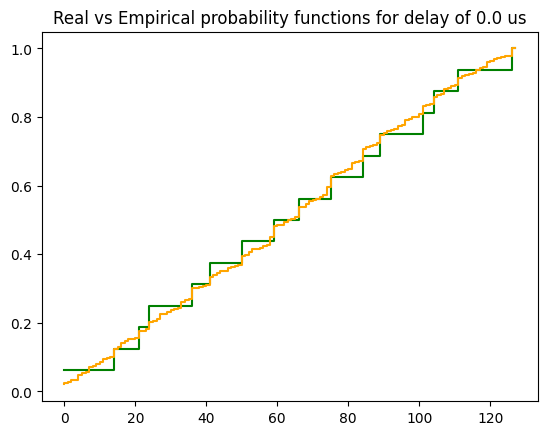

In [ ]:
real_cumulative_distribution = []
empirical_cumulative_distribution = []

total_real_distribution = 0
total_empirical_distribution = 0
for key in ordered_real_distribution.keys():

    total_real_distribution += ordered_real_distribution[key]
    total_empirical_distribution += ordered_empirical_distribution[key]
    real_cumulative_distribution.append(total_real_distribution)
    empirical_cumulative_distribution.append(total_empirical_distribution)

plt.step([i for i in range(len(real_cumulative_distribution))], real_cumulative_distribution, color='g', label='real CDF')
plt.step([i for i in range(len(real_cumulative_distribution))], empirical_cumulative_distribution, color='orange', label='empirical CDF')
plt.legend()
plt.title(f"Real vs Empirical CDF for delay of {t_array_us[time_position]} us")
plt.show()

### Second Experiment: $\text{delay\_1\_measureAll.ipynb}$ - Experiment 1

This experiment consist of encoding a $\ket{1}_L$ state in the Steane Code, add a time delay and measure the state adding. The experiment name is $\textcolor{orange}{\text{delay\_1\_measureAll\_noCorrection}}$. With this key we can extract the result of these experiment in $\textcolor{green}{\text{experiment.json}}$.

In [25]:
# Opening JSON file
experiment_name = "delay_1_measureAll_noCorrection"

result, job = get_result(json_file, experiment_name, service)

result, job

 > Job ID: cz2zdenkvm9g008fydjg
 > Job Status: DONE



({'job_id': 'cz2zdenkvm9g008fydjg',
  'metadata': {'expected_distribution': {'1111111': 0.125,
    '1110000': 0.125,
    '1001100': 0.125,
    '1000011': 0.125,
    '0101010': 0.125,
    '0100101': 0.125,
    '0011001': 0.125,
    '0010110': 0.125},
   't_array': [0,
    90000,
    180000,
    270000,
    360000,
    450000,
    540000,
    630000,
    720000,
    810000],
   'initial_layout': [122, 123, 121, 111, 124, 120, 125],
   'estimated_duration': [8.526222222222223,
    28.52622222222222,
    49.059555555555555,
    67.28888888888889,
    87.28888888888889,
    107.28888888888888,
    129.11644444444445,
    147.2888888888889,
    168.4693333333333,
    187.2888888888889],
   'encoder_type': '1',
   't_arrya_units': 'dt',
   'estimated_duration_units': 'us'}},
 <RuntimeJobV2('cz2zdenkvm9g008fydjg', 'sampler')>)

In [26]:
# Get data of result['metadata'] and backend name
real_distribution = result['metadata']['expected_distribution']
t_array = result['metadata']['t_array']
initial_layout = result['metadata']['initial_layout']
backend_name = job._backend.name # job._backend gives a IBMBackend object
pub_result = job.result()

In [27]:
# Get dt of the backend:
backend = service.backend(backend_name)
sampler = SamplerV2(backend)
# Get the dt of the selected backend in nano seconds
print(f" > dt in seconds: {backend.configuration().dt} s")
dt = backend.configuration().dt * 10**9
print(f" > dt in ns: {round(dt, 3)} ns")

 > dt in seconds: 2.2222222222222221e-10 s
 > dt in ns: 0.222 ns


In [28]:
# get t_array in us:
t_array_us = [t*dt * 10**(-3) for t in t_array]
t_array_us

[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0]

In [29]:
# Compute TVD:
tvd = []
empirical_distribution_list = []

for i in range(len(pub_result)):
    counts = pub_result[i].data.physical_bits.get_counts()
    empirical_distribution = {}

    # Recall that qiskit gives the result in reverse order:
    shots = pub_result[i].data.physical_bits.num_shots
    for j in counts.keys():
        empirical_distribution[j[::-1]] = counts[j]/shots
        
    empirical_distribution_list.append(empirical_distribution)

    print(f" > Measured TVD in {backend_name}: {round(TVD(empirical_distribution, real_distribution), 2)} (delay of {t_array_us[i]} us = {t_array[i]} dt)")

    tvd.append(TVD(empirical_distribution, real_distribution))

 > Measured TVD in ibm_sherbrooke: 0.26 (delay of 0.0 us = 0 dt)
 > Measured TVD in ibm_sherbrooke: 0.43 (delay of 20.0 us = 90000 dt)
 > Measured TVD in ibm_sherbrooke: 0.64 (delay of 40.0 us = 180000 dt)
 > Measured TVD in ibm_sherbrooke: 0.66 (delay of 60.0 us = 270000 dt)
 > Measured TVD in ibm_sherbrooke: 0.73 (delay of 80.0 us = 360000 dt)
 > Measured TVD in ibm_sherbrooke: 0.78 (delay of 100.0 us = 450000 dt)
 > Measured TVD in ibm_sherbrooke: 0.84 (delay of 120.0 us = 540000 dt)
 > Measured TVD in ibm_sherbrooke: 0.85 (delay of 140.0 us = 630000 dt)
 > Measured TVD in ibm_sherbrooke: 0.86 (delay of 160.0 us = 720000 dt)
 > Measured TVD in ibm_sherbrooke: 0.89 (delay of 180.0 us = 810000 dt)


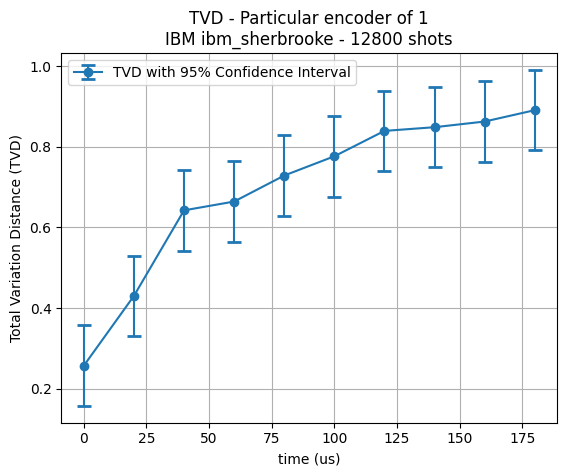

In [30]:
# plt.plot(t_array_us, tvd, 'o-g', label = 'TVD') # 'o-g' ~ 'marker|line|color' = 'o|-|green'
confidence = 0.1
lower_error = [confidence if d - confidence >= 0 else d for d in tvd]
upper_error = [confidence if d + confidence <= 1 else 1 - d for d in tvd]
error = [lower_error, upper_error]
plt.errorbar(t_array_us, tvd, yerr=error, fmt='o', capsize=5, capthick=2, linestyle='-', label="TVD with 95% Confidence Interval")

plt.legend()
plt.grid()
# plt.ylim(0, 1)
plt.xlabel("time (us)")
plt.ylabel("Total Variation Distance (TVD)")

# Here we suppose that the number of shots is equal for each circuit. 
plt.title(f"TVD - Particular encoder of 1\nIBM {backend_name} - {shots} shots")

plt.show()

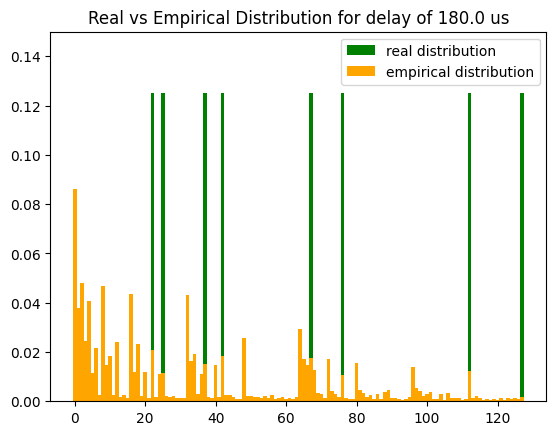

In [36]:
ordered_empirical_distribution = {}
ordered_real_distribution = {}

#time_position = 0
time_position = len(t_array) - 1

diference = {}
for i in range(2**7):
    key = bin(i)[2::]
    key = '0'*(7 - len(key)) + key

    if key in empirical_distribution_list[time_position].keys():
        ordered_empirical_distribution[i] = empirical_distribution_list[time_position][key]

    else:
        ordered_empirical_distribution[i] = 0

    if key in real_distribution.keys():
        ordered_real_distribution[i] = real_distribution[key]

    else:
        ordered_real_distribution[i] = 0

    diference[i] = abs(ordered_real_distribution[i] - ordered_empirical_distribution[i])
    
    # print('0'*(7 - len(key)) + key)

plt.bar(ordered_real_distribution.keys(), ordered_real_distribution.values(), width=1, color='g', label='real distribution')
plt.bar(ordered_empirical_distribution.keys(), ordered_empirical_distribution.values(), width=1, color='orange', label='empirical distribution')
plt.legend()
plt.ylim(0, 0.15)
plt.title(f"Real vs Empirical Distribution for delay of {t_array_us[time_position]} us")
plt.show()

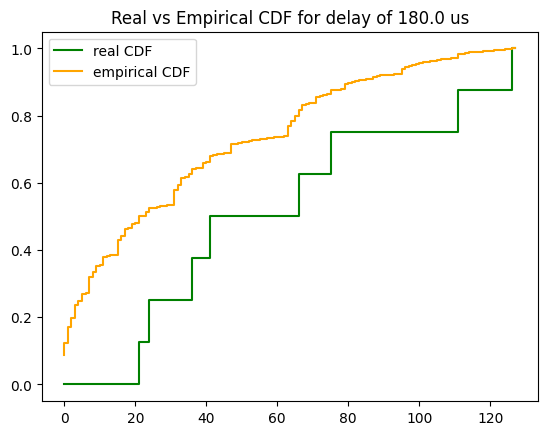

In [37]:
real_cumulative_distribution = []
empirical_cumulative_distribution = []

total_real_distribution = 0
total_empirical_distribution = 0
for key in ordered_real_distribution.keys():

    total_real_distribution += ordered_real_distribution[key]
    total_empirical_distribution += ordered_empirical_distribution[key]
    real_cumulative_distribution.append(total_real_distribution)
    empirical_cumulative_distribution.append(total_empirical_distribution)

plt.step([i for i in range(len(real_cumulative_distribution))], real_cumulative_distribution, color='g', label='real CDF')
plt.step([i for i in range(len(real_cumulative_distribution))], empirical_cumulative_distribution, color='orange', label='empirical CDF')
plt.legend()
plt.title(f"Real vs Empirical CDF for delay of {t_array_us[time_position]} us")
plt.show()